# Setup Imports

fastai.imports is a utility from the FastAI library that imports a bunch of common data science libraries in one go (like pandas, numpy, matplotlib, etc.)

In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

# Loading the excel files

In [5]:
import pandas as pd

train_df = pd.read_csv("/content/train (1).csv")
test_df = pd.read_csv("/content/test (1).csv")
submission_df = pd.read_csv("/content/gender_submission.csv")

print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

#Implementing Random Forest Model

1. Baseline Model with 5 features

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#preprocessing
train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})
train_df['Embarked'].fillna('S', inplace=True)
train_df['Embarked'] = train_df['Embarked'].map({'S':0, 'C':1, 'Q':2}) #label encoding
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

#input variable and target variable
X = train_df[['Pclass','Sex','Age','Fare','Embarked']] #using only 5 features as of now to keep the model simple
y = train_df['Survived']

#Train-Test split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size =0.2, random_state=42)

#Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#predict and evaluate
y_pred= model.predict(X_val)
print("Accuracy:",accuracy_score(y_val, y_pred))

<ipython-input-8-c03f93852f06>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna('S', inplace=True)
<ipython-input-8-c03f93852f06>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

Accuracy: 0.7262569832402235


2. Adding more features to the model

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Preprocessing

#ConvertING categorical to numeric
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
train_df['Embarked'].fillna(0, inplace=True)
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

#Feature Engineering
# Family size feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)

#ExtractING Title from Name
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
#Map common titles and group rare ones
title_map = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}
train_df['Title'] = train_df['Title'].map(title_map).fillna(4)  # Rare titles = 4

#Select Features & Target

features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
X = train_df[features]
y = train_df['Survived']

#Train/Test Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Training

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Prediction & Evaluation

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print("Model Accuracy with Extra Features:", round(accuracy * 100, 2), "%")


<ipython-input-11-86a8f946ef68>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna(0, inplace=True)
<ipython-input-11-86a8f946ef68>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Model Accuracy with Extra Features: 79.89 %


3. Trying the model with hyperparameter tuning

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up the grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1

# Run the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
tuned_accuracy = accuracy_score(y_val, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Model Accuracy after Hyperparameter Tuning:", round(tuned_accuracy * 100, 2), "%")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Accuracy after Hyperparameter Tuning: 81.01 %


In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


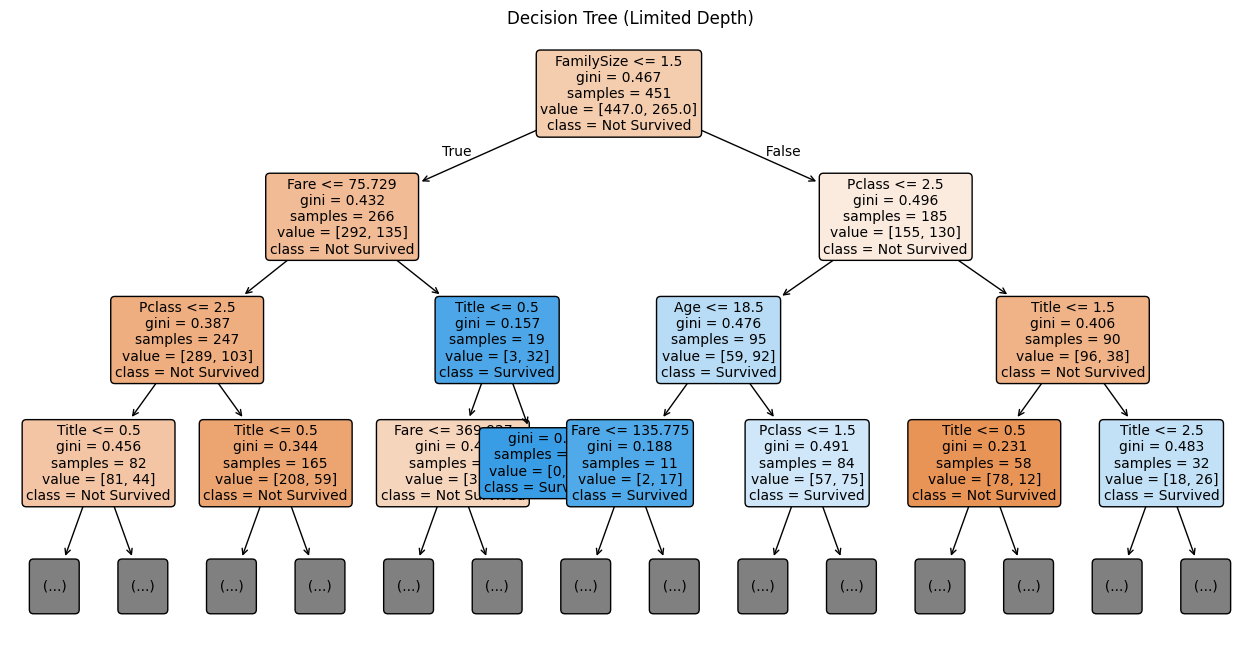

In [19]:
plt.figure(figsize=(16, 8))
plot_tree(estimator,
          feature_names=features,
          class_names=["Not Survived", "Survived"],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree (Limited Depth)")
plt.show()


This decision tree shows that passenger survival is primarily influenced by FamilySize, Fare, Pclass, and Title. Individuals with smaller families and higher class or fare, especially women and children (as seen via Title and Age), had a higher chance of survival.

#prediction on the test.csv

In [14]:
# Load test data
test_df = pd.read_csv("/content/test (1).csv")

#Match preprocessing done on train_df
# Encode categorical variables
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].fillna(0)

# Handle missing values
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

# Feature engineering
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

# Extract title
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}).fillna(4)

#Selecting the same features used in training
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
X_test = test_df[features]


#Predict with Best Model

In [15]:
# Predict using the tuned model
test_preds = best_model.predict(X_test)


Create Submission File

In [16]:
# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_preds
})


submission.to_csv("submission.csv", index=False)
print("✅ Submission file 'submission.csv' created successfully!")


✅ Submission file 'submission.csv' created successfully!
